# Scalability analysis (strong scaling)

This notebook analyzes MPI scalability for both time integrators using the CSV produced by the scalability script:

- Input: `scalability-results.csv`
- Metrics: wall time, speedup, efficiency

Speedup and efficiency are computed **per configuration** `(scheme, Nel, R, Dt, T)` using the `nprocs=1` timing as baseline.

Crank-Nicolson for the Theta method. beta=0.25, gamma=0.5 for Newmark.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")

In [2]:
csv_path = Path('scalability-results-cluster-3.csv')
df = pd.read_csv(csv_path)

# Basic cleanup / typing
df = df.copy()
df['nprocs'] = pd.to_numeric(df['nprocs'], errors='coerce')
df['Nel'] = pd.to_numeric(df['Nel'], errors='coerce')
df['R'] = pd.to_numeric(df['R'], errors='coerce')
df['Dt'] = pd.to_numeric(df['Dt'], errors='coerce')
df['T'] = pd.to_numeric(df['T'], errors='coerce')
df['seconds'] = pd.to_numeric(df['seconds'], errors='coerce')
df['returncode'] = pd.to_numeric(df['returncode'], errors='coerce')

# Keep only successful runs with valid timing
df = df[(df['returncode'] == 0) & df['seconds'].notna() & (df['seconds'] > 0)].copy()

# If duplicates exist, keep the minimum time (best run) for the same setting
dedup_keys = ['scheme', 'binary', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']
df = df.sort_values('seconds').drop_duplicates(subset=dedup_keys, keep='first')

df.head()

,scheme,binary,nprocs,repeat,Nel,R,Dt,T,Theta,Beta,Gamma,returncode,seconds,cmd,stdout_log,stderr_log
19,newmark,/scratch_local/nmpde-wave-equation_5620.login0...,16,1,320,1,0.005,5.0,NaN,0.25,0.5,0,64.348333,mpirun -np 16 --hostfile /var/spool/pbs/aux/56...,NaN,NaN
14,theta,/scratch_local/nmpde-wave-equation_5620.login0...,16,1,320,1,0.005,5.0,0.5,NaN,NaN,0,88.176021,mpirun -np 16 --hostfile /var/spool/pbs/aux/56...,NaN,NaN
18,newmark,/scratch_local/nmpde-wave-equation_5619.login0...,8,1,320,1,0.005,5.0,NaN,0.25,0.5,0,103.197500,mpirun -np 8 --hostfile /var/spool/pbs/aux/561...,NaN,NaN
9,newmark,/scratch_local/nmpde-wave-equation_5613.login0...,16,1,320,1,0.005,5.0,NaN,0.25,0.5,0,106.298448,mpirun -np 16 --hostfile /var/sp>,NaN,NaN
13,theta,/scratch_local/nmpde-wave-equation_5619.login0...,8,1,320,1,0.005,5.0,0.5,NaN,NaN,0,146.595778,mpirun -np 8 --hostfile /var/spool/pbs/aux/561...,NaN,NaN


In [3]:
# Compute strong-scaling speedup/efficiency per configuration (scheme + discretization + final time)
group_keys = ['scheme', 'Nel', 'R', 'Dt', 'T', 'Theta', 'Beta', 'Gamma']

# Baseline timings (nprocs == 1) per configuration
base = (
    df[df['nprocs'] == 1][group_keys + ['seconds']]
    .rename(columns={'seconds': 't_base'})
    .groupby(group_keys, dropna=False, as_index=False)['t_base'].min()
)

# Join baseline back and compute metrics (vectorized, no GroupBy.apply => no warning)
dfm = df.merge(base, on=group_keys, how='left')
dfm = dfm[dfm['t_base'].notna()].copy()
dfm['speedup'] = dfm['t_base'] / dfm['seconds']
dfm['efficiency'] = dfm['speedup'] / dfm['nprocs']

dfm[['scheme', 'nprocs', 'Nel', 'R', 'Dt', 'T', 'seconds', 'speedup', 'efficiency']].sort_values(['scheme','Nel','Dt','T','nprocs']).head(20)

,scheme,nprocs,Nel,R,Dt,T,seconds,speedup,efficiency
14,newmark,1,320,1,0.005,5.0,587.452833,1.000000,1.000000
17,newmark,1,320,1,0.005,5.0,876.903090,0.669918,0.669918
11,newmark,2,320,1,0.005,5.0,418.525317,1.403626,0.701813
15,newmark,2,320,1,0.005,5.0,678.182638,0.866216,0.433108
7,newmark,4,320,1,0.005,5.0,187.051056,3.140602,0.785150
10,newmark,4,320,1,0.005,5.0,314.326390,1.868926,0.467232
2,newmark,8,320,1,0.005,5.0,103.197500,5.692510,0.711564
6,newmark,8,320,1,0.005,5.0,182.770925,3.214148,0.401769
0,newmark,16,320,1,0.005,5.0,64.348333,9.129263,0.570579
3,newmark,16,320,1,0.005,5.0,106.298448,5.526448,0.345403


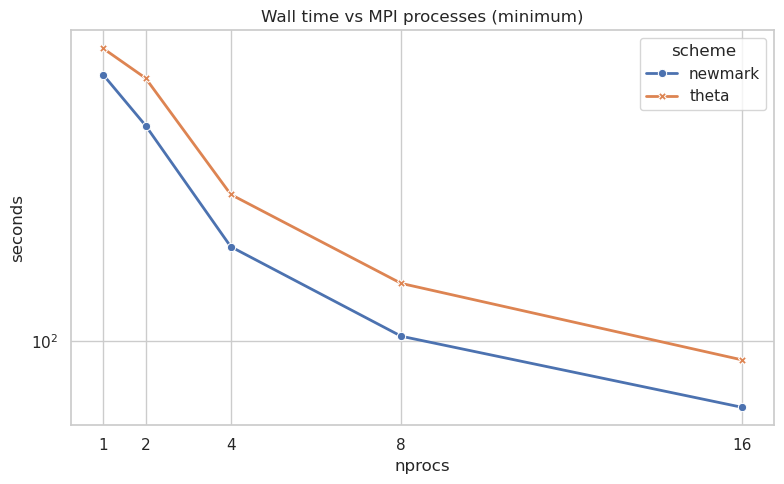

In [4]:
# Runtime vs nprocs (one curve per scheme per (Nel,Dt,T) setting if multiple exist)
plot_keys = ['scheme', 'Nel', 'R', 'Dt', 'T']
df_plot = dfm.copy()

# Build a label for the discretization/time config
df_plot['case'] = (
    'Nel=' + df_plot['Nel'].astype(int).astype(str)
    + ', R=' + df_plot['R'].astype(int).astype(str)
    + ', Dt=' + df_plot['Dt'].astype(str)
    + ', T=' + df_plot['T'].astype(str)
)

# Aggregate by taking minimum for each configuration
df_plot_agg = df_plot.groupby(['scheme', 'nprocs'], as_index=False).agg({'seconds': 'min'})

plt.figure(figsize=(8, 5))
ax = sns.lineplot(
    data=df_plot_agg, x='nprocs', y='seconds',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    errorbar=None
)
ax.set_title('Wall time vs MPI processes (minimum)')
ax.set_xlabel('nprocs')
ax.set_ylabel('seconds')
ax.set_yscale('log')
ax.set_xticks(sorted(df_plot_agg['nprocs'].unique()))
plt.tight_layout()

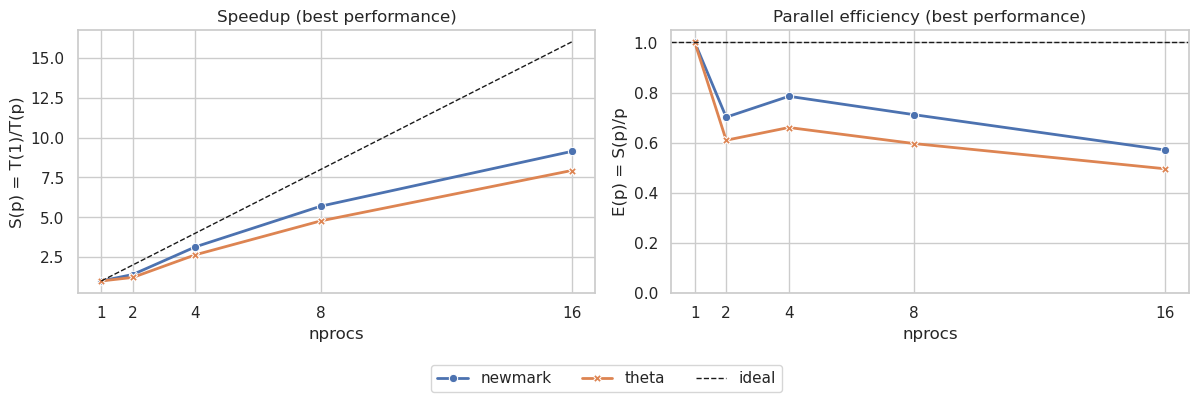

In [5]:
# Speedup and efficiency vs nprocs
# Aggregate by taking minimum for each configuration
dfm_agg = dfm.groupby(['scheme', 'nprocs'], as_index=False).agg({
    'speedup': 'max',  # max speedup corresponds to min time
    'efficiency': 'max'  # max efficiency corresponds to min time
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='speedup',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[0], errorbar=None
)
axes[0].plot([1, dfm_agg['nprocs'].max()], [1, dfm_agg['nprocs'].max()], color='k', linewidth=1, linestyle='--', label='ideal')
axes[0].set_title('Speedup (best performance)')
axes[0].set_xlabel('nprocs')
axes[0].set_ylabel('S(p) = T(1)/T(p)')
axes[0].set_xticks(sorted(dfm_agg['nprocs'].unique()))

sns.lineplot(
    data=dfm_agg, x='nprocs', y='efficiency',
    hue='scheme', style='scheme', markers=True, dashes=False, linewidth=2,
    ax=axes[1], errorbar=None
)
axes[1].axhline(1.0, color='k', linewidth=1, linestyle='--', label='ideal')
axes[1].set_title('Parallel efficiency (best performance)')
axes[1].set_xlabel('nprocs')
axes[1].set_ylabel('E(p) = S(p)/p')
axes[1].set_xticks(sorted(dfm_agg['nprocs'].unique()))
axes[1].set_ylim(0, max(1.05, float(dfm_agg['efficiency'].max()) * 1.05))

# De-duplicate legends (single legend outside)
handles, labels = axes[0].get_legend_handles_labels()
for ax in axes:
    if ax.get_legend() is not None:
        ax.get_legend().remove()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True, bbox_to_anchor=(0.5, -0.02))
fig.tight_layout(rect=[0, 0.08, 1, 1])

## Profiling analysis (Newmark, Teuchos StackedTimer)

The anomalous **E(2) < E(4)** dip in parallel efficiency is explained by **cache/NUMA effects**, not MPI communication overhead.

### Hardware context (Intel Xeon Gold 6238R × 2)
- 2 sockets, 28 cores/socket, 38.5 MB L3/socket
- 2 NUMA nodes (even CPUs → node 0, odd → node 1)

### Timer-based breakdown (Nel=320, R=1, dt=0.005)

| Component | n=2 (s) | n=4 (s) | Speedup | Category |
|---|---|---|---|---|
| `rhs:cell_loop` | 0.916 | 0.601 | 1.52× | local |
| `solve:CG` | 3.382 | 2.112 | 1.60× | mixed (SpMV + Allreduce) |
| `solve:precond_init` | 1.210 | 0.755 | 1.60× | local |
| `solve:BC_setup` | 0.581 | 0.412 | 1.41× | local |
| `rhs:vmult` | 0.098 | 0.221 | 0.44× | **MPI** (ghost exchange) |
| `rhs:compress` | 0.032 | 0.058 | 0.55× | **MPI** (Allreduce) |
| `norms` | 0.010 | 0.006 | 1.67× | **MPI** (Allreduce) |
| **output (I/O)** | **5.477** | **3.220** | 1.70× | I/O |

### Key findings
1. **I/O dominates**: `output` is ~45% of wall time → must disable with `NMPDE_SAVE_SOLUTION=0` for clean benchmarks
2. **MPI communication is small**: only ~2–7% of compute time (excluding I/O)
3. **E(2) < E(4) is a cache/NUMA effect**: at n=4, per-process working set (~6 MB) fits well in L3 cache (38.5 MB/socket), and NUMA locality improves with 2 ranks per socket
4. **CG iteration count grows with nprocs** (5.25/step at n=2 → 5.75/step at n=4): SSOR preconditioner quality degrades with more subdomains